## MSA similarity plot

In [ ]:
# Imports
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display, clear_output
import os

### User input initialisation

In [ ]:
# Create interactive widgets for user input
file_path_layout = widgets.Layout(width='80%')
top_n_widget = widgets.IntText(
    value=20,
    description='Top N species:',
    disabled=False,
    style={'description_width': 'initial'}
)

a3m_path_widget = widgets.Text(
    value='uniref.a3m',
    description='A3M file path:',
    disabled=False,
    layout=file_path_layout,
    style={'description_width': 'initial'}
)

db_path_widget = widgets.Text(
    value='uniref_species.db',
    description='Database path:',
    disabled=False,
    layout=file_path_layout,
    style={'description_width': 'initial'}
)

# Display widgets
print("Please configure the analysis parameters:")
display(top_n_widget)
display(a3m_path_widget)
display(db_path_widget)

# Store the values for use in other cells
top_n = top_n_widget.value
a3m_path = a3m_path_widget.value
db_path = db_path_widget.value

print(f"\nConfiguration set:")
print(f"Top N: {top_n}")
print(f"A3M file: {a3m_path}")
print(f"Database: {db_path}")



### Pipeline functions

In [ ]:
# Combine A3M similarity scores with species lookup table
def load_and_merge_data(a3m_path, db_path):
    try:
        # 1. Load species lookup from database
        conn = sqlite3.connect(db_path)
        species_lookup = pd.read_sql("SELECT uniref_id, species FROM uniref_species", conn)
        conn.close()
        
        if species_lookup.empty:
            raise ValueError("Species lookup table is empty!")
        
        # 2. Parse A3M file with validation
        data = []
        invalid_headers = 0
        
        with open(a3m_path) as f:
            for line in f:
                if line.startswith('>'):
                    parts = line.strip().split()
                    
                    # Validate header structure
                    if len(parts) < 3:
                        invalid_headers += 1
                        continue
                        
                    try:
                        uniref_id = parts[0][1:]  # Remove '>'
                        similarity = float(parts[2])
                        
                        # Validate values
                        if not (0 <= similarity <= 1):
                            invalid_headers += 1
                            continue
                            
                        data.append({"uniref_id": uniref_id, "similarity": similarity})
                        
                    except (ValueError, IndexError):
                        invalid_headers += 1
                        continue
        
        if invalid_headers > 0:
            print(f"Warning: Skipped {invalid_headers} invalid headers")
        
        if not data:
            raise ValueError("No valid sequences found in A3M file!")
        
        # 3. Merge and clean data
        similarity_df = pd.DataFrame(data)
        merged = pd.merge(similarity_df, species_lookup, on="uniref_id", how="left")
        merged["species"].fillna("Unknown", inplace=True)
        
        print(f"Successfully loaded {len(merged)} sequences")
        return merged
        
    except Exception as e:
        print(f"Error in load_and_merge_data: {str(e)}")
        return None

In [ ]:
# Data processing. Return top N most similar sequences with only one entry per species
def get_top_unique_species(df, top_n=20):
    if df is None:
        raise ValueError("Input DataFrame is None - check data loading")
    
    try:
        # Sort by similarity in descending order
        sorted_df = df.sort_values("similarity", ascending=False)
        
        # Keep only the highest similarity entry for each species
        unique_species = sorted_df.drop_duplicates(subset="species", keep="first")
        
        # Take top N and prepare labels
        top_df = unique_species.head(top_n).copy()
        top_df["rank"] = range(1, len(top_df) + 1)
        top_df["label"] = top_df.apply(
            lambda x: f"{x['species']} ({x['uniref_id']})", 
            axis=1
        )
        
        print(f"Found {len(top_df)} unique species")
        return top_df
        
    except Exception as e:
        print(f"Error in get_top_unique_species: {str(e)}")
        raise

In [ ]:
# VVisualise top unique species by highest similarity
def plot_top_unique_species(top_df, top_n=20):
    if top_df is None or len(top_df) == 0:
        raise ValueError("No valid data available for plotting!")
    
    try:
        plt.figure(figsize=(12, 8))
        sns.set_style("whitegrid")
        palette = sns.color_palette("viridis_r", n_colors=top_n)
        
        # Create bar plot
        ax = sns.barplot(
            data=top_df,
            x="similarity",
            y="label",
            palette=palette,
            edgecolor="black",
            linewidth=0.5,
            dodge=False
        )
        
        # Annotate bars with similarity scores
        for i, (_, row) in enumerate(top_df.iterrows()):
            ax.text(
                row["similarity"] + 0.01, i,
                f"{row['similarity']:.3f}",
                va="center",
                fontsize=9
            )
        
        # Styling
        plt.title(f"Top {len(top_df)} Species by Highest Sequence Similarity", fontsize=14, pad=20)
        plt.xlabel("Similarity Score", fontsize=12)
        plt.ylabel("Species (UniRef ID)", fontsize=12)
        plt.xlim(0, 1.1)
        plt.xticks(
            [0, 0.2, 0.4, 0.6, 0.8, 1.0],
            ["0%", "20%", "40%", "60%", "80%", "100%"]
        )
        sns.despine(left=True)
        plt.tight_layout()
        
        # Save and show
        plt.savefig("top_unique_species_similarity.png", dpi=300, bbox_inches="tight")
        print("Plot saved successfully!")
        plt.show()
        
    except Exception as e:
        print(f"Error in plotting: {str(e)}")
        raise

### Analysis pipeline

In [ ]:
# Execute the analysis pipeline
def run_analysis():
    try:
        # Get current values from widgets
        current_top_n = top_n_widget.value
        current_a3m_path = a3m_path_widget.value
        current_db_path = db_path_widget.value
        
        print("Starting analysis pipeline...")
        print(f"Configuration: Top N={current_top_n}, A3M={current_a3m_path}, DB={current_db_path}")
        
        # 1. Load and validate data
        print("\n[1/3] Loading and merging data...")
        merged_data = load_and_merge_data(current_a3m_path, current_db_path)
        
        if merged_data is not None:
            print("\nData sample:")
            display(merged_data[['uniref_id', 'species', 'similarity']].head())
            
            # 2. Process data
            print("\n[2/3] Filtering top unique species...")
            top_species = get_top_unique_species(merged_data, top_n=current_top_n)
            
            if not top_species.empty:
                print("\nTop species found:")
                display(top_species[['species', 'similarity', 'rank']])
                
                # 3. Visualise results
                print("\n[3/3] Generating visualisation...")
                plot_top_unique_species(top_species, top_n=current_top_n)
            else:
                print("No species met the criteria!")
        else:
            print("Data loading failed - cannot continue")
            
    except Exception as e:
        print(f"\nPipeline failed: {str(e)}")
    finally:
        print("\nAnalysis complete")

### Run the analysis

Starting analysis pipeline...
Configuration: Top N=20, A3M=uniref.a3m, DB=uniref_species.db

[1/3] Loading and merging data...
Successfully loaded 7085 sequences

Data sample:


/var/folders/lz/vcct75k53vq1m6txppkd6z0r0000gn/T/ipykernel_2942/3208872151.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged["species"].fillna("Unknown", inplace=True)


,uniref_id,species,similarity
0,UniRef100_A8T6A1,Ateles geoffroyi,0.888
1,UniRef100_A0A669KAY4,Homo sapiens,0.984
2,UniRef100_UPI001362B05D,Unknown,0.936
3,UniRef100_A0A8C3WY28,Catagonus wagneri,0.825
4,UniRef100_A8T677,Plecturocebus moloch,0.850



[2/3] Filtering top unique species...
Found 20 unique species

Top species found:


,species,similarity,rank
6200,Homo sapiens,1.000,1
1444,Unknown,0.966,2
7079,Sicista betulina,0.951,3
1445,Ateles geoffroyi,0.942,4
7055,Muridae,0.937,5
1446,Callithrix jacchus,0.933,6
1447,Plecturocebus moloch,0.930,7
7083,Myomorpha,0.911,8
7071,Rhombomys opimus,0.897,9
1448,Carlito syrichta,0.868,10



[3/3] Generating visualization...


/var/folders/lz/vcct75k53vq1m6txppkd6z0r0000gn/T/ipykernel_2942/1423348760.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


Plot saved successfully!


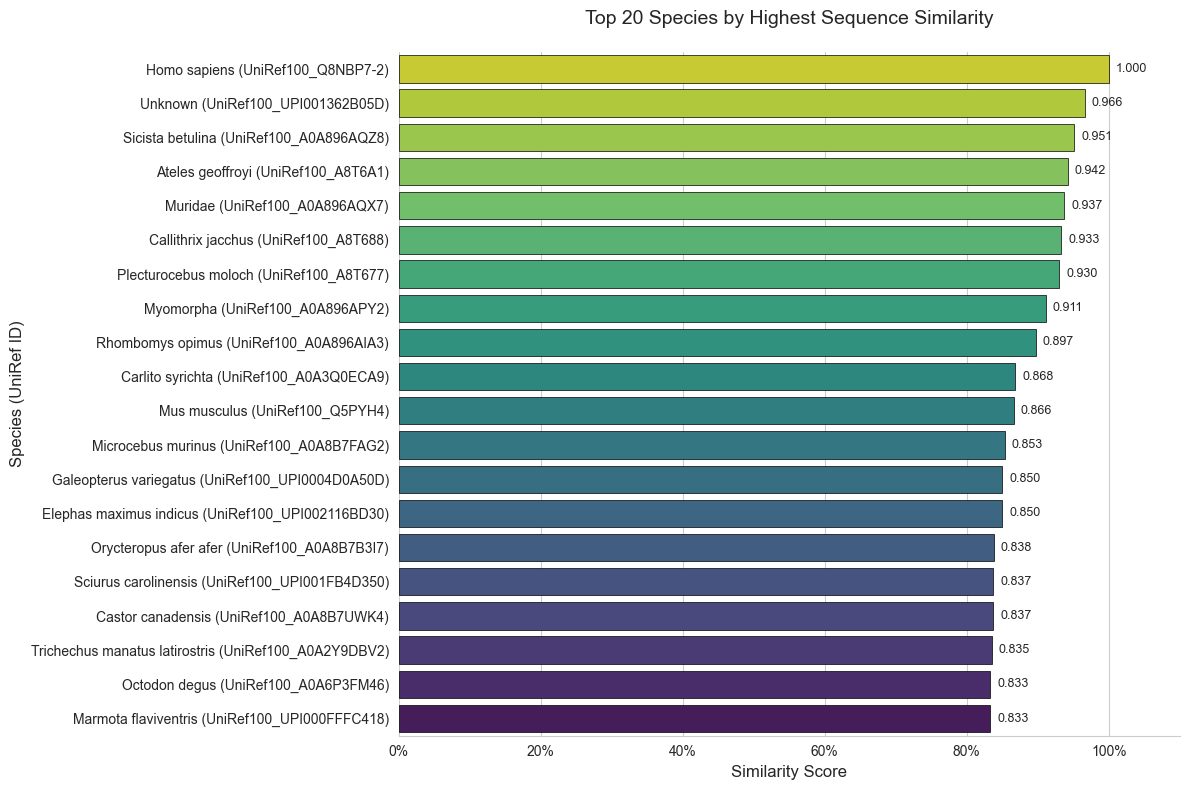


Analysis complete


In [15]:
run_analysis()